<a href="https://colab.research.google.com/github/bouchrabenkhelifa/PFE-Exp03-Time-Series/blob/main/TS_Forecasting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nombre de points de données : 144
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


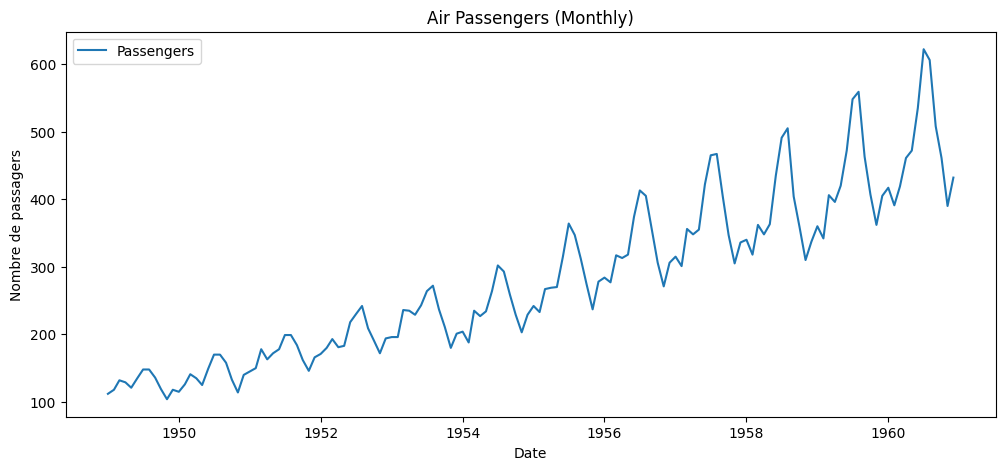

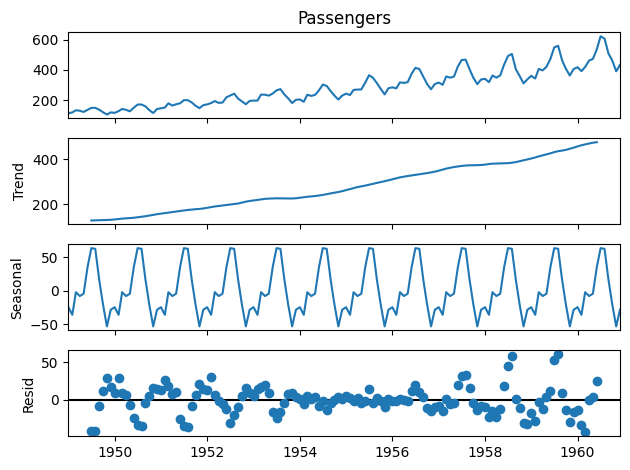

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Télécharger le dataset depuis GitHub
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

print("Nombre de points de données :", len(df))
print(df.head())

# Visualisation de la série
plt.figure(figsize=(12,5))
plt.plot(df['Passengers'], label='Passengers')
plt.title("Air Passengers (Monthly)")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.show()

# Décomposition pour tendance et saisonnalité
decomposition = seasonal_decompose(df['Passengers'], model='additive', period=12)  # 12 mois par cycle
decomposition.plot()
plt.show()


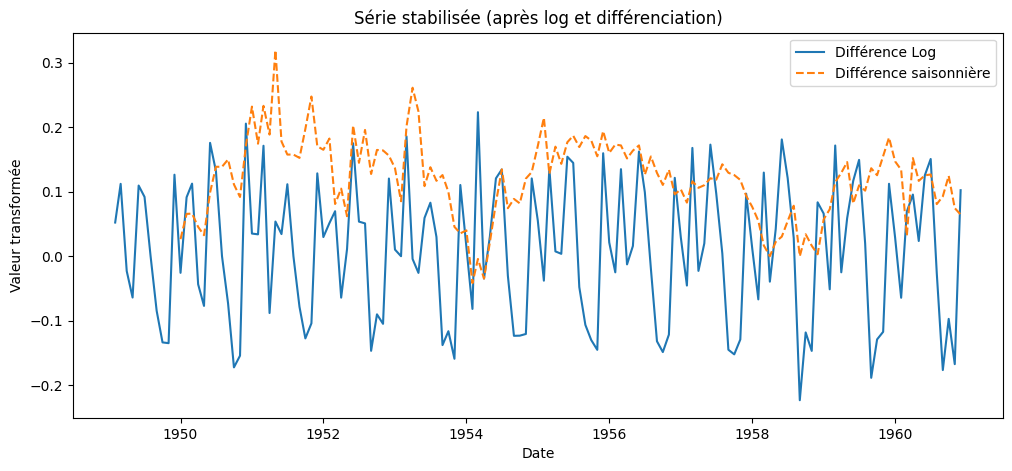

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffPassengers'] = df['LogPassengers'].diff()
df['SeasonalDiff'] = df['LogPassengers'] - df['LogPassengers'].shift(12)
plt.figure(figsize=(12,5))
plt.plot(df['DiffPassengers'], label='Différence Log')
plt.plot(df['SeasonalDiff'], label='Différence saisonnière', linestyle='--')
plt.title("Série stabilisée (après log et différenciation)")
plt.xlabel("Date")
plt.ylabel("Valeur transformée")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

df['LogPassengers'] = np.log(df['Passengers'])
df['DiffPassengers'] = df['LogPassengers'].diff()
df = df.dropna(subset=['DiffPassengers'])

values = df[['DiffPassengers']].values
scaler = StandardScaler()
scaled_values = scaler.fit_transform(values)

def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_values, window_size)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerForecaster(nn.Module):
    def __init__(self, feature_size=8, num_layers=2, nhead=2, hidden_dim=64):
        super().__init__()
        self.positional_encoding = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=hidden_dim, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(feature_size, 1)

    def forward(self, x):
        x = self.positional_encoding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])

model = TransformerForecaster()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().numpy()
    true = y_test.squeeze().numpy()




Epoch 10/100, Loss: 0.959962
Epoch 20/100, Loss: 0.960267
Epoch 30/100, Loss: 0.913916
Epoch 40/100, Loss: 0.896658
Epoch 50/100, Loss: 0.827765
Epoch 60/100, Loss: 0.674971
Epoch 70/100, Loss: 0.501594
Epoch 80/100, Loss: 0.458378
Epoch 90/100, Loss: 0.279820
Epoch 100/100, Loss: 0.358296


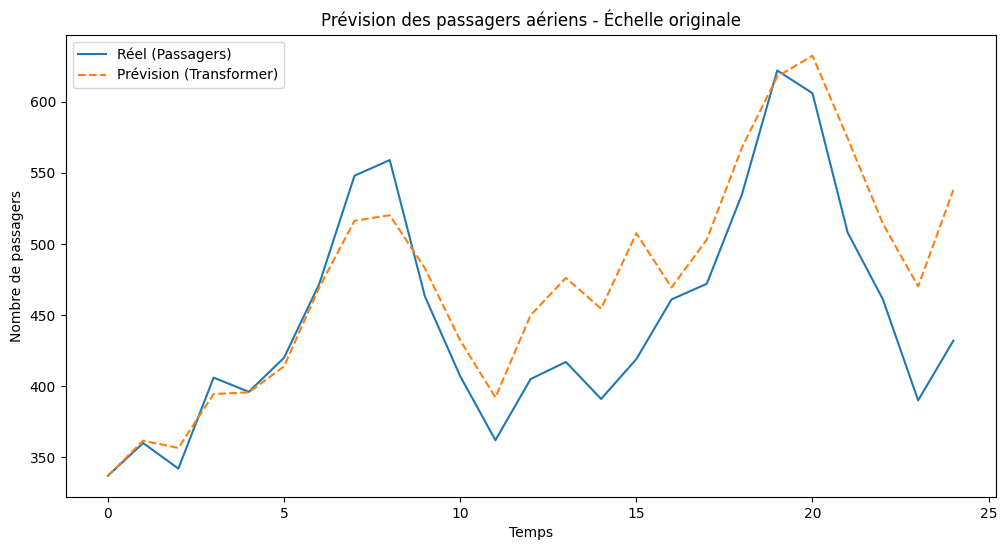

RMSE (échelle originale) : 44.695
MAPE : 7.72%


In [ ]:
preds_inv = scaler.inverse_transform(preds.reshape(-1, 1))
true_inv = scaler.inverse_transform(true.reshape(-1, 1))

# récupérer la dernière vraie valeur connue avant la série test
last_log_value = df['LogPassengers'].iloc[train_size + window_size - 1]

# reconstruire la série log à partir des différences prédites
preds_log = np.r_[last_log_value, last_log_value + np.cumsum(preds_inv.flatten())]
true_log = np.r_[last_log_value, last_log_value + np.cumsum(true_inv.flatten())]

# revenir à l’échelle d’origine
preds_original = np.exp(preds_log)
true_original = np.exp(true_log)

# visualisation
plt.figure(figsize=(12,6))
plt.plot(true_original, label='Réel (Passagers)')
plt.plot(preds_original, label='Prévision (Transformer)', linestyle='--')
plt.title("Prévision des passagers aériens - Échelle originale")
plt.xlabel("Temps")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.show()

# métriques d'erreur
from sklearn.metrics import mean_squared_error
mse_original = mean_squared_error(true_original, preds_original)
rmse_original = np.sqrt(mse_original)

print(f"RMSE (échelle originale) : {rmse_original:.3f}")

# MAPE (pourcentage d'erreur)
mape = np.mean(np.abs((true_original - preds_original) / true_original)) * 100
print(f"MAPE : {mape:.2f}%")
